In [4]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment


In [ ]:
X, GT = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
plot_clusters(X, GT, "Ground Truth")

In [ ]:
C = SpectralClustering(n_clusters=2,
        assign_labels='discretize', 
        random_state=42).fit(X)

plot_clusters(X, C.labels_, title = "Spectral Clustering")

In [ ]:
# accuracy
def calculate_aligned_accuracy(ground_truth, cluster_labels):
    true_labels = ground_truth.flatten()
    cm = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    label_mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
    aligned_labels = np.array([label_mapping[label] for label in cluster_labels])

    accuracy = np.mean(aligned_labels == true_labels)

    return accuracy

In [ ]:
accuracy = calculate_aligned_accuracy(GT, C.labels_)
print("Aligned Accuracy:", accuracy)

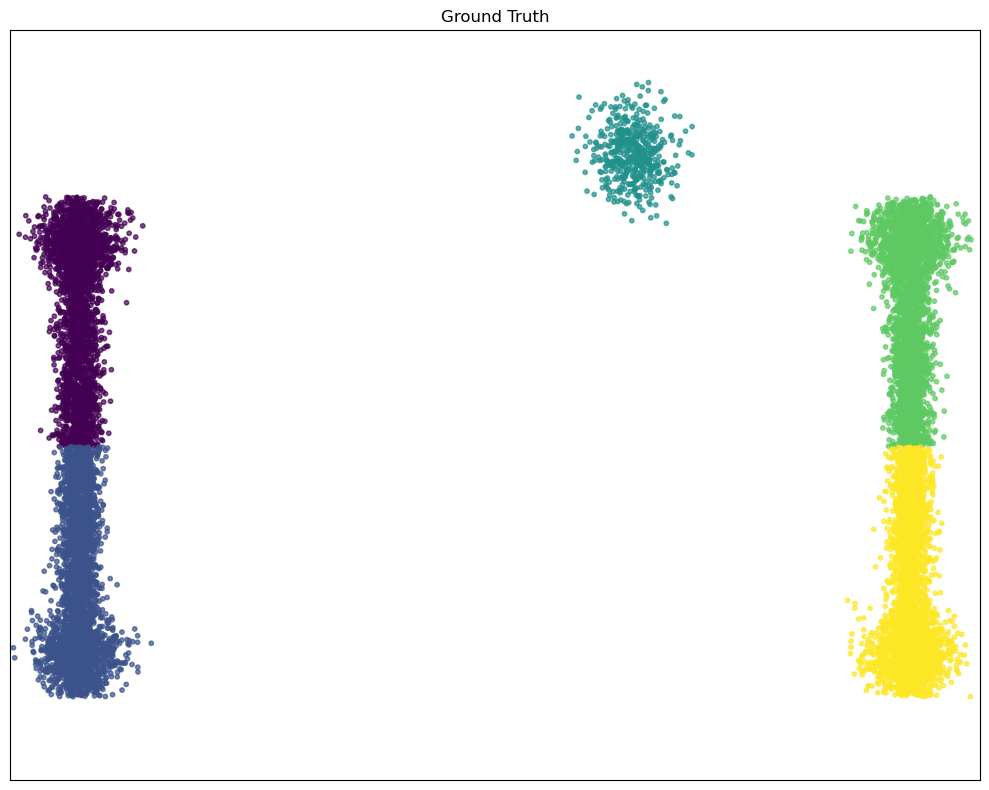

X shape: (11741, 2)
GT shape: (11741,)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def generate_split_dumbbell_cluster(n_points, center, x_spread, y_spread, end_thickness):
    top_half = np.random.normal(loc=(center[0], center[1] + y_spread/2), 
                                scale=(x_spread, y_spread/2), 
                                size=(n_points//2, 2))
    bottom_half = np.random.normal(loc=(center[0], center[1] - y_spread/2), 
                                   scale=(x_spread, y_spread/2), 
                                   size=(n_points//2, 2))
    top_end = np.random.normal(loc=(center[0], center[1] + y_spread), 
                               scale=(x_spread * end_thickness, y_spread * 0.1), 
                               size=(n_points//4, 2))
    bottom_end = np.random.normal(loc=(center[0], center[1] - y_spread), 
                                  scale=(x_spread * end_thickness, y_spread * 0.1), 
                                  size=(n_points//4, 2))
    all_points = np.vstack((top_half, bottom_half, top_end, bottom_end))
    mask = (all_points[:, 1] >= center[1] - y_spread * 1.2) & (all_points[:, 1] <= center[1] + y_spread * 1.2)
    return all_points[mask]

def generate_compact_cluster(n_points, center, spread):
    return np.random.normal(loc=center, scale=spread, size=(n_points, 2))

def plot_ground_truth():
    left_dumbbell = generate_split_dumbbell_cluster(4000, center=(0, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    right_dumbbell = generate_split_dumbbell_cluster(4000, center=(12, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    center_cluster = generate_compact_cluster(500, center=(8, 6.5), spread=0.3)
    
    left_top = left_dumbbell[left_dumbbell[:, 1] > 3]
    left_bottom = left_dumbbell[left_dumbbell[:, 1] <= 3]
    right_top = right_dumbbell[right_dumbbell[:, 1] > 3]
    right_bottom = right_dumbbell[right_dumbbell[:, 1] <= 3]
    
    # Combine all points into X
    X = np.vstack((left_top, left_bottom, center_cluster, right_top, right_bottom))
    
    # Create labels
    labels = np.concatenate([
        np.zeros(len(left_top)),
        np.ones(len(left_bottom)),
        np.full(len(center_cluster), 2),
        np.full(len(right_top), 3),
        np.full(len(right_bottom), 4)
    ])
    
    # Create GT (y-coordinates)
    GT = X[:, 1]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10, alpha=0.7)
    
    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 8)
    ax.set_title("Ground Truth")
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    plt.tight_layout()
    plt.show()
    
    return X, GT, labels

# Generate and plot data
X, GT, labels = plot_ground_truth()

tsne_X = TSNE(n_components=2, random_state=42)
X = tsne_X.fit_transform(X)

# Apply t-SNE to GT (reshape GT to 2D array)
# GT_2D = GT.reshape(-1, 1)
# tsne_GT = TSNE(n_components=2, random_state=42)
# GT = tsne_GT.fit_transform(GT_2D)


print("X shape:", X.shape)
print("GT shape:", GT.shape)

In [2]:
# Just subsample 10%

total_samples = X.shape[0]
subsample_size = int(total_samples * 0.1)  # 10% of the original data

# Generate random indices for subsampling
random_indices = np.random.choice(total_samples, subsample_size, replace=False)

# Subsample X and GT
X = X[random_indices]
GT = GT[random_indices]

print(f"X.shape: {X.shape}\nGT.shape: {GT.shape}")

X.shape: (1174, 2)
GT.shape: (1174,)


In [6]:
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()

/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited at iteration 586 with accuracies 
[2.32022061e-15 1.40576104e-05 3.72975233e-05 1.72589864e-05]
not reaching the requested tolerance 1.749396324157715e-05.
Use iteration 569 instead with accuracy 
1.0661721518819915e-05.

  _, diffusion_map = lobpcg(
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[2.20026929e-15 1.44949389e-05 8.87659786e-06 1.92753490e-05]
not reaching the requested tolerance 1.749396324157715e-05.
  _, diffusion_map = lobpcg(


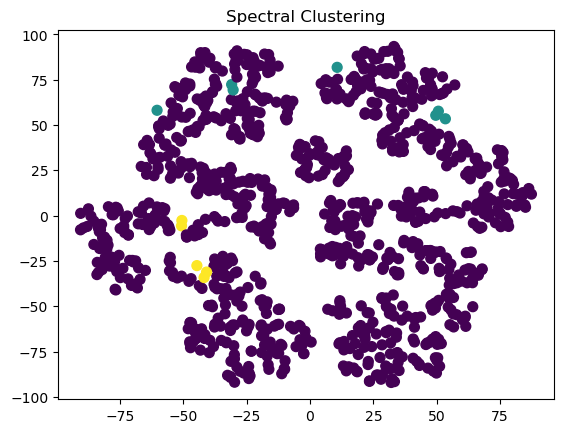

In [7]:
C = SpectralClustering(n_clusters=3,
        assign_labels='discretize', 
        random_state=42).fit(X)

plot_clusters(X, C.labels_, title = "Spectral Clustering")

In [9]:
GT = GT.astype(int)
accuracy = calculate_aligned_accuracy(GT, C.labels_)
print("Aligned Accuracy:", accuracy)

Aligned Accuracy: 0.24701873935264054
